In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, MSTL, AutoTheta

from mlforecast import MLForecast
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean
from mlforecast.target_transforms import AutoDifferences

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


C:\Users\user\anaconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import data

In [2]:
hos_rate_age_sex_df = pd.read_csv("scenario_b_data/Hospital Admission Rate by Age and Sex.csv")

In [3]:
pop_2001_2010 = pd.read_excel("scenario_b_data/respopagesextod2000to2020e.xlsx", sheet_name="2001-2010(Total)", skiprows=2)
pop_2011_2019 = pd.read_excel("scenario_b_data/respopagesextod2000to2020e.xlsx", sheet_name="2011-2019(Total)", skiprows=2)
pop_2020 = pd.read_excel("scenario_b_data/respopagesextod2000to2020e.xlsx", sheet_name="2020(Total)", skiprows=2)

# Preprocessing (DataFrame Manipulation)

In [4]:
# Filter for Acute facility type
modified_hos_rate_df = hos_rate_age_sex_df[hos_rate_age_sex_df["facility_type_a"] == "Acute"]

# Calculate the Admission number
modified_hos_rate_df["admin_num"] = round(modified_hos_rate_df["rate"] * 1000)

# Drop unwanted columns
modified_hos_rate_df = modified_hos_rate_df.drop(columns=["facility_type_a", "rate"])

# Group by year, age and sum numeric columns
admin_df = modified_hos_rate_df.groupby(["year"]).sum().reset_index()

admin_df

C:\Users\user\AppData\Local\Temp\ipykernel_14920\704705234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_hos_rate_df["admin_num"] = round(modified_hos_rate_df["rate"] * 1000)
C:\Users\user\AppData\Local\Temp\ipykernel_14920\704705234.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admin_df = modified_hos_rate_df.groupby(["year"]).sum().reset_index()


,year,admin_num
0,2009,931900.0
1,2010,965200.0
2,2011,1001500.0
3,2012,1015200.0
4,2013,1016800.0
5,2014,1034500.0
6,2015,1032600.0
7,2016,1114500.0
8,2017,1130300.0
9,2018,1131100.0


In [5]:
pop_dict = {}
target_area =  ["Boon Lay", "Bukit Batok", "Bukit Panjang", "Chua Chu Kang", "Clementi", "Jurong East", "Jurong West", "Pioneer", "Tengah", "Tuas", "Western Islands", "Western Water Catchment"]

In [6]:
modified_pop_2001_2010 = pop_2001_2010[pop_2001_2010["Planning Area"].isin(target_area)]

modified_pop_2001_2010 = modified_pop_2001_2010[
                        (modified_pop_2001_2010["Subzone"] == "Total") &
                        (modified_pop_2001_2010["Age Group"] == "Total") &
                        (modified_pop_2001_2010["Type of Dwelling"] == "Total")
                    ]

# Replace '-' with 0 in the entire DataFrame
modified_pop_2001_2010 = modified_pop_2001_2010.replace('-', 0)

for year in range(2001, 2011):
    pop_dict[year] = modified_pop_2001_2010[str(year)].sum()

In [7]:
modified_pop_2011_2019 = pop_2011_2019[pop_2011_2019["Planning Area"].isin(target_area)]

modified_pop_2011_2019 = modified_pop_2011_2019[
                        (modified_pop_2011_2019["Subzone"] == "Total") &
                        (modified_pop_2011_2019["Age Group"] == "Total") &
                        (modified_pop_2011_2019["Type of Dwelling"] == "Total")
                    ]

# Replace '-' with 0 in the entire DataFrame
modified_pop_2011_2019 = modified_pop_2011_2019.replace('-', 0)

for year in range(2011, 2020):
    pop_dict[year] = modified_pop_2011_2019[str(year)].sum()

In [8]:
modified_pop_2020 = pop_2020[pop_2020["Planning Area"].isin(target_area)]

modified_pop_2020 = modified_pop_2020[
                        (modified_pop_2020["Subzone"] == "Total") &
                        (modified_pop_2020["Age Group"] == "Total") &
                        (modified_pop_2020["Type of Dwelling"] == "Total")
                    ]

# Replace '-' with 0 in the entire DataFrame
modified_pop_2020 = modified_pop_2020.replace('-', 0)

pop_dict[2020] = modified_pop_2020["2020"].sum()

In [9]:
pop_df = pd.DataFrame(list(pop_dict.items()), columns=['year', 'pop_num'])

# Merge the original DataFrame with the dictionary DataFrame
merged_df = pd.merge(admin_df, pop_df, on='year', how='left')
merged_df

,year,admin_num,pop_num
0,2009,931900.0,716560
1,2010,965200.0,721690
2,2011,1001500.0,722730
3,2012,1015200.0,724470
4,2013,1016800.0,724750
5,2014,1034500.0,725490
6,2015,1032600.0,728680
7,2016,1114500.0,727060
8,2017,1130300.0,725180
9,2018,1131100.0,727060


# Forecasting Population

In [10]:
n_train = 10
n_forecast = 2
n_window = int(np.ceil((2037 - 2020) / 2))

In [11]:
pop_forecast = pop_df.copy()

pop_forecast["ds"] = pd.to_datetime(pop_forecast["year"].astype(str) + "-12-31")

# Rename the pop_num column to y
pop_forecast = pop_forecast.rename(columns={
            "year": "unique_id",
            "pop_num": "y"
        })

pop_forecast["unique_id"] = "1.0"

pop_forecast = pop_forecast[["unique_id", "ds", "y"]]
pop_forecast["avg_models"] = "-"

pop_forecast

,unique_id,ds,y,avg_models
0,1.0,2001-12-31,627320,-
1,1.0,2002-12-31,642780,-
2,1.0,2003-12-31,643220,-
3,1.0,2004-12-31,652260,-
4,1.0,2005-12-31,661590,-
5,1.0,2006-12-31,671550,-
6,1.0,2007-12-31,681380,-
7,1.0,2008-12-31,695280,-
8,1.0,2009-12-31,716560,-
9,1.0,2010-12-31,721690,-


In [12]:
for n in range(n_window):
    df = pop_forecast[-n_train:][['unique_id', 'ds', 'y']]
    
    sf = StatsForecast(
        df = df,
        models=[
            AutoARIMA(season_length=3),
            AutoETS(season_length=3),
            AutoCES(season_length=3),
            MSTL(season_length=3),
            AutoTheta(season_length=3)
        ],
        freq='Y'
    )
    
    crossvalidation_df = sf.cross_validation(
        df = df,
        h = n_forecast,
        step_size = 2,
        n_windows = 1
    )
    
    sf.fit(df)
    final_pred = sf.predict(h=n_forecast)
    
    model_names = [model for model in crossvalidation_df.columns if model not in ["ds", "cutoff", "y"]]

    model_mse = pd.DataFrame({
        "model": model_names,
        "mse": [mean_squared_error(crossvalidation_df['y'], crossvalidation_df[model]) for model in model_names]
    })

    top_3_models = model_mse.nsmallest(3, 'mse')
    best_models = top_3_models["model"].tolist()

    final_pred["ensemble"] = final_pred[best_models].mean(axis=1)
    final_pred["avg_models"] = ', '.join(best_models)
    
    modified_result = final_pred[["ds", "ensemble", "avg_models"]].copy().rename(columns={"ensemble": "y"})
    modified_result["unique_id"] = "1.0"
    
    # Append the forecast results
    pop_forecast = pd.concat([pop_forecast, modified_result])
    
pop_forecast


C:\Users\user\anaconda3\Lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\statsforecast\ets.py:1038: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
C:\Users\user\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to 

,unique_id,ds,y,avg_models
0,1.0,2001-12-31,627320.0000,-
1,1.0,2002-12-31,642780.0000,-
2,1.0,2003-12-31,643220.0000,-
3,1.0,2004-12-31,652260.0000,-
4,1.0,2005-12-31,661590.0000,-
5,1.0,2006-12-31,671550.0000,-
6,1.0,2007-12-31,681380.0000,-
7,1.0,2008-12-31,695280.0000,-
8,1.0,2009-12-31,716560.0000,-
9,1.0,2010-12-31,721690.0000,-


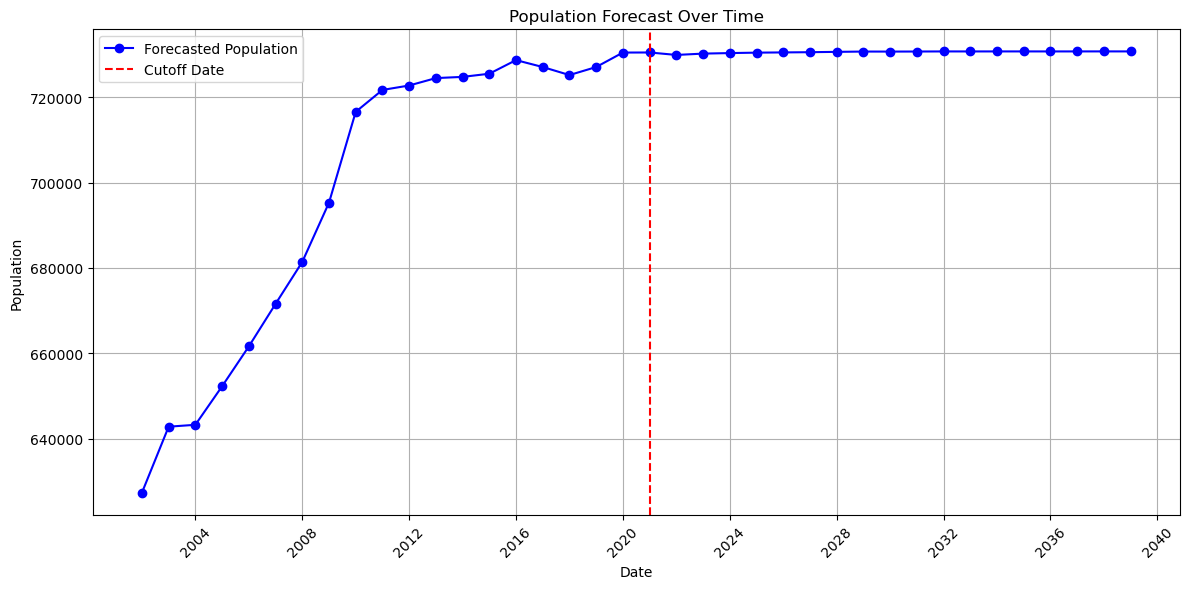

In [13]:
# Plotting the Population Forecast
plt.figure(figsize=(12, 6))
plt.plot(pop_forecast['ds'], pop_forecast['y'], marker='o', label='Forecasted Population', color='blue')
plt.title('Population Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.grid()
plt.axvline(x=pd.to_datetime("2020-12-31"), linestyle='--', color='red', label='Cutoff Date')
plt.legend()
plt.tight_layout()
plt.show()

# Forecasting Hospital Admission

In [14]:
n_window = int(np.ceil((2035 - 2020) / 2))

In [15]:
admin_forecast = merged_df.copy()

admin_forecast["ds"] = pd.to_datetime(admin_forecast["year"].astype(str) + "-12-31")

# Rename the pop_num column to y
admin_forecast = admin_forecast.rename(columns={
            "year": "unique_id",
            "admin_num": "y"
        })

admin_forecast["unique_id"] = "1.0"
admin_forecast = admin_forecast[["unique_id", "ds", "pop_num", "y"]]
admin_forecast["avg_models"] = "-"

admin_forecast

,unique_id,ds,pop_num,y,avg_models
0,1.0,2009-12-31,716560,931900.0,-
1,1.0,2010-12-31,721690,965200.0,-
2,1.0,2011-12-31,722730,1001500.0,-
3,1.0,2012-12-31,724470,1015200.0,-
4,1.0,2013-12-31,724750,1016800.0,-
5,1.0,2014-12-31,725490,1034500.0,-
6,1.0,2015-12-31,728680,1032600.0,-
7,1.0,2016-12-31,727060,1114500.0,-
8,1.0,2017-12-31,725180,1130300.0,-
9,1.0,2018-12-31,727060,1131100.0,-


In [16]:
transformed_exo_df = transform_exog(
                        pop_forecast[["unique_id", "ds", "y"]].rename(columns={"y": "pop_num"}), 
                        lags=[1,2,3],
                        lag_transforms={
                            1: [ExponentiallyWeightedMean(alpha=0.75)],
                        },
                    )

transformed_exo_df

,unique_id,ds,pop_num,pop_num_lag1,pop_num_lag2,pop_num_lag3,pop_num_exponentially_weighted_mean_lag1_alpha0.75
0,1.0,2001-12-31,627320.0000,NaN,NaN,NaN,NaN
1,1.0,2002-12-31,642780.0000,627320.0000,NaN,NaN,627320.000000
2,1.0,2003-12-31,643220.0000,642780.0000,627320.0000,NaN,638915.000000
3,1.0,2004-12-31,652260.0000,643220.0000,642780.0000,627320.0000,642143.750000
4,1.0,2005-12-31,661590.0000,652260.0000,643220.0000,642780.0000,649730.937500
5,1.0,2006-12-31,671550.0000,661590.0000,652260.0000,643220.0000,658625.234375
6,1.0,2007-12-31,681380.0000,671550.0000,661590.0000,652260.0000,668318.808594
7,1.0,2008-12-31,695280.0000,681380.0000,671550.0000,661590.0000,678114.702148
8,1.0,2009-12-31,716560.0000,695280.0000,681380.0000,671550.0000,690988.675537
9,1.0,2010-12-31,721690.0000,716560.0000,695280.0000,681380.0000,710167.168884


In [17]:
ml_models = {
    "LGB": lgb.LGBMRegressor(),
    "CatBoost": CatBoostRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "SVM": SVR()
}

In [18]:
pop_df = pop_forecast[["unique_id", "ds", "y"]]

for n in range(n_window):
    df = admin_forecast[-n_train:][["unique_id", "ds", "pop_num", "y"]]
    
    # Filter rows where that are the future
    exo_df = pop_df[pop_df["ds"] > df["ds"].max()]

    # Rename the column 'y' to 'pop_num'
    exo_df = exo_df.rename(columns={"y": "pop_num"})

    # Merge Transformed features
    exo_df = exo_df.merge(transformed_exo_df, on=['unique_id', 'ds', 'pop_num'])
    
    df_with_exo = df.merge(transformed_exo_df, on=['unique_id', 'ds', 'pop_num'])
    
    fcst = MLForecast(
        models=ml_models,
        freq='Y',
        lags=[1,2,3],
        lag_transforms={
            1: [ExponentiallyWeightedMean(alpha=0.75)],
        },
        target_transforms = [AutoDifferences(max_diffs=10)],
    )
    
    fcst.fit(df_with_exo, static_features=[])
    
    preds = fcst.predict(h=n_forecast, X_df=exo_df)
    
    cv_df = fcst.cross_validation(
        df=df_with_exo,
        h=n_forecast,
        n_windows=1,
        static_features = []
    )
    
    model_names = list(ml_models.keys())
    
    model_mse = pd.DataFrame({
        "model": model_names,
        "mse": [mean_squared_error(cv_df["y"], cv_df[model]) for model in model_names]
    })
    
    top_3_models = model_mse.nsmallest(3, "mse")
    best_models = top_3_models["model"].tolist()

    preds["ensemble"] = preds[best_models].mean(axis=1)
    preds["avg_models"] = ", ".join(best_models)

    modified_result = preds[["unique_id", "ds", "ensemble", "avg_models"]].copy().rename(columns={"ensemble": "y"})
    modified_result = modified_result.merge(exo_df[["unique_id", "ds", "pop_num"]],
                                           how="left",
                                           on=["unique_id", "ds"])
    
    admin_forecast = pd.concat([admin_forecast, modified_result]).reset_index(drop=True)
    
admin_forecast
    

C:\Users\user\AppData\Local\Temp\ipykernel_14920\2943282293.py:15: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_with_exo = df.merge(transformed_exo_df, on=['unique_id', 'ds', 'pop_num'])


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7, number of used features: 0
[LightGBM] [Info] Start training from score 1083585.714286
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+05, tolerance: 6.630e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+05, tolerance: 6.630e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] Start training from score 1062950.675000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.650e+02, tolerance: 7.385e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.186e+03, tolerance: 7.385e+01
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] Start training from score -200.007744
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+02, tolerance: 4.794e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.350e+01, tolerance: 4.794e+01
  model = cd_fast.enet_coordinate_descent(


,unique_id,ds,pop_num,y,avg_models
0,1.0,2009-12-31,716560.0000,9.319000e+05,-
1,1.0,2010-12-31,721690.0000,9.652000e+05,-
2,1.0,2011-12-31,722730.0000,1.001500e+06,-
3,1.0,2012-12-31,724470.0000,1.015200e+06,-
4,1.0,2013-12-31,724750.0000,1.016800e+06,-
5,1.0,2014-12-31,725490.0000,1.034500e+06,-
6,1.0,2015-12-31,728680.0000,1.032600e+06,-
7,1.0,2016-12-31,727060.0000,1.114500e+06,-
8,1.0,2017-12-31,725180.0000,1.130300e+06,-
9,1.0,2018-12-31,727060.0000,1.131100e+06,-


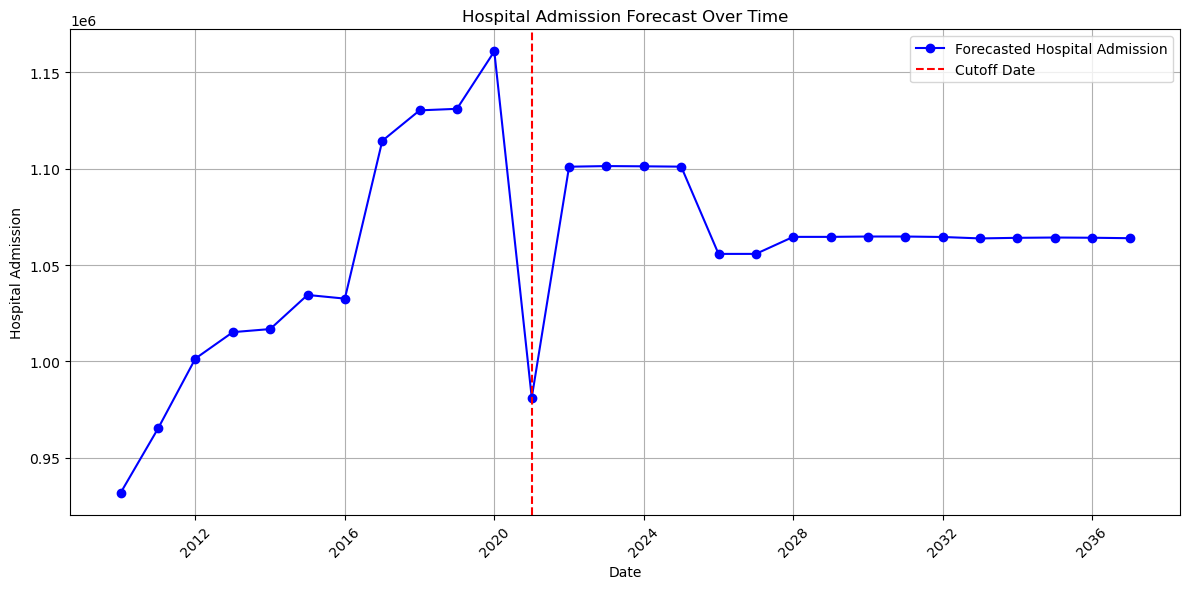

In [19]:
# Plotting the Population Forecast
plt.figure(figsize=(12, 6))
plt.plot(admin_forecast['ds'], admin_forecast['y'], marker='o', label='Forecasted Hospital Admission', color='blue')
plt.title('Hospital Admission Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Hospital Admission')
plt.xticks(rotation=45)
plt.grid()
plt.axvline(x=pd.to_datetime("2020-12-31"), linestyle='--', color='red', label='Cutoff Date')
plt.legend()
plt.tight_layout()
plt.show()